In [83]:
#this is on the R4 Instance
#as of 5-26-18
import os
import csv
import pymysql as mc 
import time
import webbrowser
import sys
from sklearn.cluster import KMeans
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.preprocessing import scale
import matplotlib as mpl
mpl.rc('figure',figsize=[12,8])
from sqlalchemy import create_engine
from sqlalchemy.types import VARCHAR

In [2]:
import getpass

In [4]:
pw = getpass.getpass()

········


In [39]:
cnx = mc.connect(user='akashgoyal',password=pw,
                 host='stromberg.cs.uchicago.edu',db='mlb_practicum',port=3306)

In [6]:
query = "SELECT * FROM PitcherPercentages"
df = pd.read_sql_query(query,cnx)

In [9]:
pData = Cluster_Data(cnx,'pitcher')

In [40]:
query2 = "SELECT playerID, CONCAT(firstName,' ',lastName) AS player_name FROM Distinct_Players"
named_df = pd.read_sql_query(query2,cnx)

In [44]:
comb_df = pData.df.merge(named_df,how='inner',left_index=True,right_on='playerID').set_index('player_name').drop(columns=['playerID'])
comb_df.head()

,change_up,curve,cutter,four_seam,knuckleball,sinker,slider,two_seam
player_name,,,,,,,,
Miguel Batista,0.038272,0.006481,0.002160,0.186420,0.0,0.463580,0.303086,0.000000
Chris Carpenter,0.032513,0.233846,0.232213,0.098762,0.0,0.402666,0.000000,0.000000
Bartolo Colon,0.156682,0.000000,0.000000,0.299201,0.0,0.000000,0.093635,0.450482
Elmer Dessens,0.062682,0.043732,0.000000,0.260933,0.0,0.000000,0.209913,0.422741
LaTroy Hawkins,0.034524,0.073153,0.000000,0.699662,0.0,0.000000,0.177451,0.015210


In [88]:
x_range = np.linspace(0.08,0.13,6)
df_classed = pData.df.copy()
for i in x_range:
    ms = MeanShift(bandwidth=i)
    ms.fit(pData.df)
    df_classed[f'cls_bandwidth_{int(i*100)}'] = ms.labels_
    print (df_classed.columns.values)

['change_up' 'curve' 'cutter' 'four_seam' 'knuckleball' 'sinker' 'slider'
 'two_seam' 'cls_bandwidth_8']
['change_up' 'curve' 'cutter' 'four_seam' 'knuckleball' 'sinker' 'slider'
 'two_seam' 'cls_bandwidth_8' 'cls_bandwidth_9']
['change_up' 'curve' 'cutter' 'four_seam' 'knuckleball' 'sinker' 'slider'
 'two_seam' 'cls_bandwidth_8' 'cls_bandwidth_9' 'cls_bandwidth_10']
['change_up' 'curve' 'cutter' 'four_seam' 'knuckleball' 'sinker' 'slider'
 'two_seam' 'cls_bandwidth_8' 'cls_bandwidth_9' 'cls_bandwidth_10'
 'cls_bandwidth_11']
['change_up' 'curve' 'cutter' 'four_seam' 'knuckleball' 'sinker' 'slider'
 'two_seam' 'cls_bandwidth_8' 'cls_bandwidth_9' 'cls_bandwidth_10'
 'cls_bandwidth_11' 'cls_bandwidth_12']
['change_up' 'curve' 'cutter' 'four_seam' 'knuckleball' 'sinker' 'slider'
 'two_seam' 'cls_bandwidth_8' 'cls_bandwidth_9' 'cls_bandwidth_10'
 'cls_bandwidth_11' 'cls_bandwidth_12' 'cls_bandwidth_13']


In [89]:
#send to database
user = 'akashgoyal'
host = 'stromberg.cs.uchicago.edu'
db_name = 'mlb_practicum'

cnx2 = create_engine('mysql+pymysql://'+user+':'+pw+'@'+host+':3306/'+db_name,echo=False)

df_classed.to_sql(name='pitcher_ms_clusters_5_26_18',con=cnx2,if_exists='append',
               index=True,index_label='playerID',dtype={None:VARCHAR(20)})

In [67]:
x_range = np.linspace(0.05,0.25,11)
max_count = []
number_groups = []
for i in x_range:
    ms = MeanShift(bandwidth=i)
    ms.fit(comb_df)
    max_count.append((np.unique(ms.labels_,return_counts=True)[1]).max())
    number_groups.append(len(np.unique(ms.labels_)))
    print (i,len(np.unique(ms.labels_)),max_count)

0.05 1112 [17]
0.07 752 [17, 37]
0.09 502 [17, 37, 79]
0.11 301 [17, 37, 79, 84]
0.13 171 [17, 37, 79, 84, 140]
0.15000000000000002 97 [17, 37, 79, 84, 140, 244]
0.16999999999999998 57 [17, 37, 79, 84, 140, 244, 369]
0.19 33 [17, 37, 79, 84, 140, 244, 369, 537]
0.21000000000000002 21 [17, 37, 79, 84, 140, 244, 369, 537, 803]
0.22999999999999998 14 [17, 37, 79, 84, 140, 244, 369, 537, 803, 887]
0.25 9 [17, 37, 79, 84, 140, 244, 369, 537, 803, 887, 994]


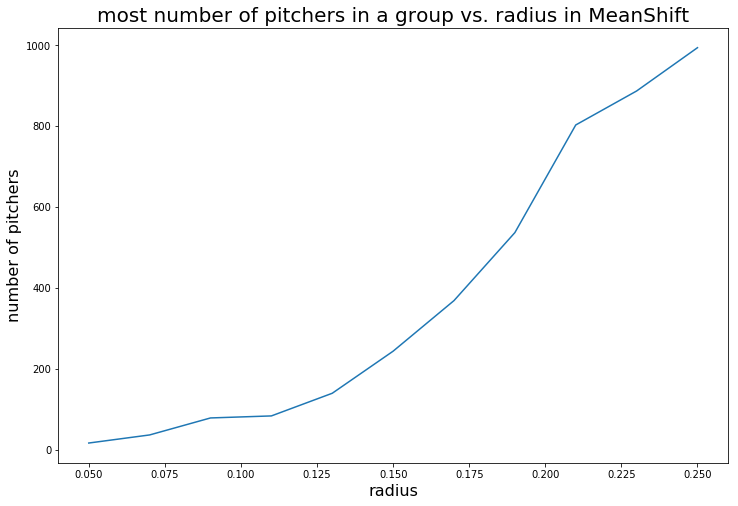

In [72]:
plt.title('most number of pitchers in a group vs. radius in MeanShift',
         fontsize=20)
plt.xlabel('radius',fontsize=16)
plt.ylabel('number of pitchers',fontsize=16)
plt.plot(x_range,max_count)

Text(0.5,1,'Radius vs. number of groups/max count in MeanShift')

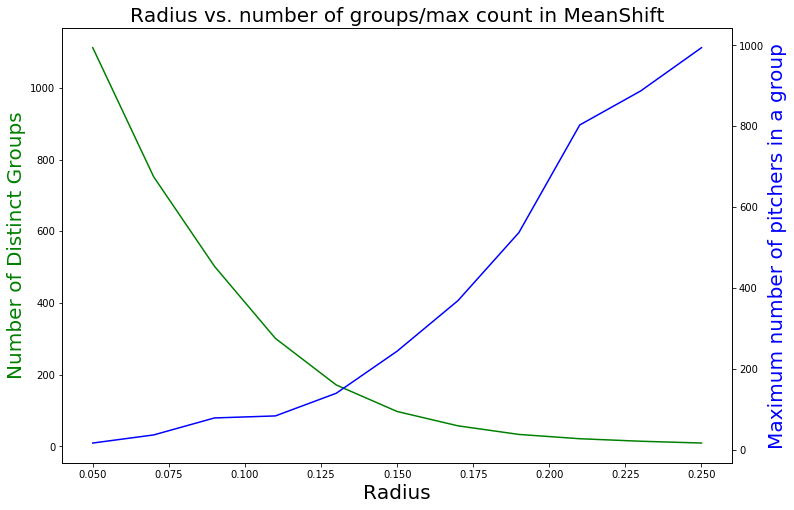

In [76]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x_range,number_groups,'g-')
ax2.plot(x_range,max_count,'b-')
ax1.set_xlabel('Radius')
ax1.set_ylabel('Number of Distinct Groups',color='g')
ax2.set_ylabel('Maximum number of pitchers in a group',color='b')

ax1.xaxis.label.set_size(20)
ax1.yaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)
plt.title('Radius vs. number of groups/max count in MeanShift',
         fontsize=20)


In [53]:
print(labeled_df.groupby('classes')['classes'].count())

classes
0      52
1      16
2      13
3      21
4      11
5      18
6      14
7      18
8      18
9      13
10     17
11     27
12     17
13     10
14     10
15     12
16     20
17     14
18     14
19     10
20     12
21     10
22      8
23     12
24      8
25      9
26     11
27     11
28      9
29      9
       ..
587     1
588     1
589     1
590     1
591     1
592     1
593     1
594     1
595     1
596     1
597     1
598     1
599     1
600     1
601     2
602     1
603     4
604     1
605     1
606     1
607     2
608     1
609     1
610     1
611     1
612     1
613     1
614     1
615     1
616     1
Name: classes, Length: 617, dtype: int64


In [37]:
x_range = np.linspace(2,10,9)
inertias = []
for i in x_range:
    kmObj = KMeans(n_clusters=int(i))
    clusters = kmObj.fit_predict(pData.df)
    inertias.append(kmObj.inertia_)
    print (int(i),kmObj.inertia_)

2 142.38453983059418
3 108.26730187085214
4 94.14225454761095
5 85.8551663317531
6 78.29330413893864
7 72.15208450654883
8 67.48235641676854
9 63.58817473688516
10 60.20576694527505


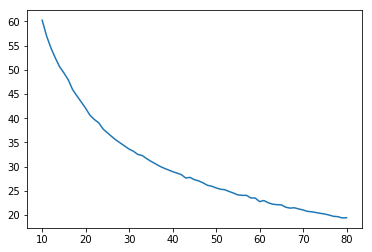

In [36]:
plt.plot(x_range,inertias)

In [8]:
class Cluster_Data:
    def __init__(self,cnx,playerType='pitcher'):
        self.cnx = cnx
        self.playerType = playerType
        #ignore the terrible naming here...
        self.df_pitcher = pd.read_sql_query('SELECT {}, pitchType FROM Pitch2'.format(playerType+'ID'),cnx)
        self.reclassify_pitches(self.df_pitcher)
        self.df = self.create_table(self.df_pitcher)

    def reclassify_pitches(self,df):
        four_seam = ['FF','FA']
        slider = ['SL']
        two_seam = ['FT']
        change_up = ['CH']
        sinker = ['SI','FS']
        knuckleball = ['KN']
        curve = ['CU','KC']
        cutter = ['FC']
        na = ['IN','PO','FO','EP','SC','UN','AB']
        l = []
        i = 2
        for row in df.itertuples():
            if row[i] in four_seam:
                l.append('four_seam')
            elif row[i] in slider:
                l.append('slider')
            elif row[i] in two_seam:
                l.append('two_seam')
            elif row[i] in change_up:
                l.append('change_up')
            elif row[i] in sinker:
                l.append('sinker')
            elif row[i] in knuckleball:
                l.append('knuckleball')
            elif row[i] in curve:
                l.append('curve')
            elif row[i] in cutter:
                l.append('cutter')
            else:
                l.append(None)
        df['new_pitch_type']=l 
        return df

    def create_table(self,df):
        if self.playerType == 'pitcher':
            table = pd.pivot_table(df,values=['new_pitch_type'],columns=['new_pitch_type'],
                               index=['pitcherID'],aggfunc='count')
        else:
            table = pd.pivot_table(df,values=['new_pitch_type'],columns=['new_pitch_type'],
                               index=['batterID'],aggfunc='count')
        table.fillna(value=0,inplace=True)
        players = {}
        for row in table.itertuples():
            total = 0
            freqList = []
            for i in range(1,9):
                total+=row[i]

            for i in range(1,9):
                freqList.append(row[i]/total)

            freqList.append(total)
            players[row[0]] = freqList
            
        player_df = pd.DataFrame.from_dict(players,orient='index')
        player_df.columns=["change_up","curve","cutter","four_seam",
                           "knuckleball","sinker","slider","two_seam","total_pitches"]
        condensed_df = player_df[player_df['total_pitches']>100]
        condensed_df = condensed_df.drop('total_pitches',axis=1)
        return condensed_df 